# [Bonus Tasks](svm_segm.ipynb)

In [140]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.ndimage as ndi
import skimage.morphology as morph
import skimage.util 
from skimage.util import view_as_windows
from skimage.filters import threshold_otsu
from skimage.util import view_as_blocks
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [141]:
def blend_result(img, seg, border_radius=1, interior_opacity=1, interior_opacity_decay=0.9, color=(0,1,0)):
    img  = np.dstack([img] * 3).copy()
    img -= img.min()
    img /= img.max()
    selem  = morph.disk(border_radius)
    seg_bd = np.logical_xor(morph.binary_dilation(seg, selem), morph.binary_erosion(seg, selem))
    mask_decay = ndi.distance_transform_edt(seg)
    for i in range(3):
        opacity = interior_opacity / pow(1 + mask_decay[seg], interior_opacity_decay)
        img[:,:,i][seg] = color[i] * opacity + (1 - opacity) * img[:,:,i][seg]
        img[:,:,i][seg_bd] = color[i]
    return img

In [142]:
patch_sizes = (32, 32)

---

**[Task 1.1.]()** Implement `create_data_matrix`:

In [143]:
def create_data_matrix(img):
    blocks = view_as_blocks(img, block_shape=patch_sizes)

    patches = blocks.reshape(-1, patch_sizes[0], patch_sizes[1]) # -1 zählt automatisch die Anzahl der Patches

    X = patches.reshape(patches.shape[0], -1) # -1 multipliziert 32 und 32 zu 1024
    return X # ergebnis ist eine Matrix mit der Form (Anzahl der Patches, 1024)
    



**[Task 1.2.]()** Implement `create_gt_labels_vector`:

In [144]:
def create_labels_vector(gt_image):

    blocks = view_as_blocks(gt_image, block_shape=patch_sizes)

    patches = blocks.reshape(-1, patch_sizes[0], patch_sizes[1]) # -1 zählt automatisch die Anzahl der Patches

    num_patches = patches.shape[0]

    y = np.zeros(num_patches, dtype=int)

    patch_area = patch_sizes[0] * patch_sizes[1]

    for i in range(num_patches):
        patch = patches[i]
        fg = np.sum(patch) 
        fg_prozent = fg / patch_area

        if fg_prozent > 0.5: # mehr als 50% Vordergrund
            y[i] = 1
        elif fg_prozent == 0 : #kein Vordergrund
            y[i] = 0
        else:
            y[i] = -1 # mehr als 0% und weniger als 50% Vordergrund

    return y

**[Task 1.3.]()** Create the SVM classifier:

In [145]:
clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced', gamma=0.1))

**[Task 1.3 (a).]()** Create the data matrices for the images `dna-33` and `dna-44`:

In [146]:
dna_33 = plt.imread("data/NIH3T3/im/dna-33.png")
dna_44 = plt.imread("data/NIH3T3/im/dna-44.png")


M_33 = create_data_matrix(dna_33)
M_44 = create_data_matrix(dna_44)


**[Task 1.3 (b).]()** Create the corresponding ground truth label vectors:

In [147]:
gt_33 = plt.imread("data/NIH3T3/gt/33.png") 
gt_44 = plt.imread("data/NIH3T3/gt/44.png")

gt_M_33 = create_labels_vector(gt_33)
gt_M_44 = create_labels_vector(gt_44)   


**[Task 1.3 (c).]()** Create the *combined* data matrices and ground truth label vectors:

In [148]:
mask_33 = (gt_M_33 != 0) # boolean maske, die alle patches mit label -1 ausschließt
mask_44 = (gt_M_44 != 0)

M_33_True = M_33[mask_33] # nur die patches, die in der maske True sind
M_44_True = M_44[mask_44]

gt_M_33_True = gt_M_33[mask_33]
gt_M_44_True = gt_M_44[mask_44]

m_combined = np.concatenate((M_33_True, M_44_True), axis=0)
gt_combined = np.concatenate((gt_M_33_True, gt_M_44_True), axis=0)

print("Combined data matrix shape:", m_combined.shape)
print("Combined labels vector shape: " + str(gt_combined.shape) + 
      "\nAnzahl der Patches: " + str(gt_combined.shape[0]) + 
      "\nPixel pro Patch: " + str(patch_sizes[0] * patch_sizes[1]))



Combined data matrix shape: (1124, 1024)
Combined labels vector shape: (1124,)
Anzahl der Patches: 1124
Pixel pro Patch: 1024


**[Task 1.3 (d).]()** Train the classifier using the data matrix and label vectors from above:

In [149]:
clf.fit(m_combined, gt_combined)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', gamma=0.1))])

**[Task 1.4.]()** Implement the function `predict_image`:

In [150]:
def predict_image(img):
    blocks = view_as_blocks(img, block_shape=patch_sizes)
    patches = blocks.reshape(-1, patch_sizes[0], patch_sizes[1])
    X = patches.reshape(patches.shape[0], -1)

    predicted_labels = clf.predict(X)

    binary_result = np.zeros((img.shape[0], img.shape[1]), dtype=bool)

    patch_height, patch_width = patch_sizes
    idx = 0
    for i in range(0, img.shape[0], patch_height):
        for j in range(0, img.shape[1], patch_width):
            if predicted_labels[idx] == 1:
                binary_result[i:i+patch_height, j:j+patch_width] = True
            idx += 1

    return binary_result

Test your implementation:

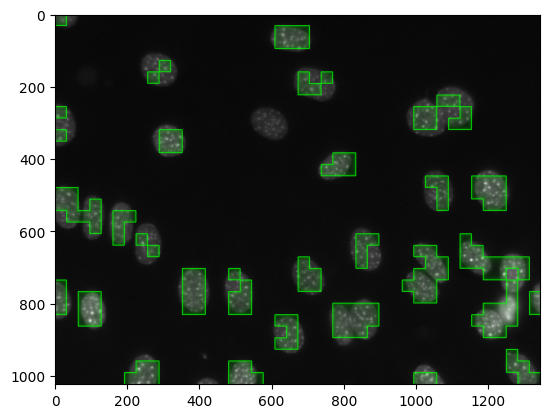

In [151]:
img = plt.imread(f'data/NIH3T3/im/dna-0.png')
seg = predict_image(img)

plt.figure()
plt.imshow(blend_result(img, seg))

**[Task 1.5.]()** Perform batch processing:

In [152]:

from skimage.filters import threshold_otsu

image_indices = [28, 29, 33, 44, 46, 49]

dice_scores = []
dice_scores_otsu = []

patch_sizes = (32, 32)

for i in image_indices:
   
    img = plt.imread(f'data/NIH3T3/im/dna-{i}.png')

    gt = plt.imread(f'data/NIH3T3/gt/{i}.png')

    gt_binary = gt > 0  # bollean ob bild binär 

    seg_result = predict_image(img)

    intersection = np.logical_and(seg_result, gt_binary).sum()
    dice = 2 * intersection / (seg_result.sum() + gt_binary.sum())
    dice_scores.append(dice)


    otsu_thresh = threshold_otsu(img)
    seg_otsu = img > otsu_thresh
    intersection_otsu = np.logical_and(seg_otsu, gt_binary).sum()
    dice_otsu = 2 * intersection_otsu / (seg_otsu.sum() + gt_binary.sum())
    dice_scores_otsu.append(dice_otsu)

    print(f"Bild {i}: Dice score SVM = {dice:.6f}, Dice Otsu = {dice_otsu:.4f}")

mean_dice = np.mean(dice_scores)
print(f"Mean Dice score: {mean_dice:.4f}")
print(f'Mean Dice Otsu: {np.mean(dice_scores_otsu):.4f}')

Bild 28: Dice score SVM = 0.694885, Dice Otsu = 0.7529
Bild 29: Dice score SVM = 0.673316, Dice Otsu = 0.6476
Bild 33: Dice score SVM = 0.670432, Dice Otsu = 0.4652
Bild 44: Dice score SVM = 0.732252, Dice Otsu = 0.5758
Bild 46: Dice score SVM = 0.631377, Dice Otsu = 0.0761
Bild 49: Dice score SVM = 0.713584, Dice Otsu = 0.7925
Mean Dice score: 0.6860
Mean Dice Otsu: 0.5517


**[Task 2.1.]()** Overlapping patches:

In [153]:
from skimage.util import view_as_windows


def predict_image_sliding_window(img, clf, patch_sizes=(32,32), step_size=16):

    patch_height, patch_width = patch_sizes
    img_height, img_width = img.shape


    windows = view_as_windows(img, patch_sizes, step=step_size)
    
    n_rows, n_cols, _, _ = windows.shape
    
    X = windows.reshape(-1, patch_height*patch_width)
    
    predicted_labels = clf.predict(X)  # +1/-1
    
    binary_result = np.zeros(img.shape, dtype=float) 
    count_matrix = np.zeros(img.shape, dtype=float)   # zählt, wie oft ein Pixel überlappt
    
    idx = 0
    for r in range(n_rows):
        for c in range(n_cols):
            start_r = r*step_size
            start_c = c*step_size
            end_r = start_r + patch_height
            end_c = start_c + patch_width
            
            if predicted_labels[idx] == 1:
                binary_result[start_r:end_r, start_c:end_c] += 1  # Pixel "stimmen" summieren
            count_matrix[start_r:end_r, start_c:end_c] += 1
            idx += 1
    
    # Durchschnitt bilden bei überlappenden Pixeln
    binary_result = binary_result / count_matrix
    binary_result = binary_result > 0.5  # >50% Stimmen → True
    
    return binary_result


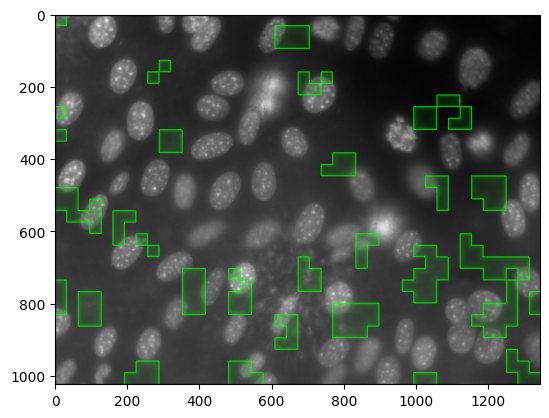

In [154]:
slide_img = plt.imread(f'data/NIH3T3/im/dna-0.png')
slide_seg = predict_image_sliding_window(img, clf, step_size=16)

plt.figure()
plt.imshow(blend_result(img, seg))

In [155]:
from skimage.filters import sobel


patch = img[0:patch_sizes[0], 0:patch_sizes[1]]  # extract first patch

patch_feature = sobel(patch) 
X_patch = patch_feature.flatten()


from sklearn.decomposition import PCA

# Use the existing combined data matrix (m_combined) as the data matrix X
# Each row in m_combined is a patch (already available in the notebook)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(m_combined)  # Training using m_combined


In [156]:
from skimage.filters import gaussian

def histogram_of_gaussians(patch, sigmas=[1,2,4], bins=16):
    features = []
    for sigma in sigmas:
        filtered = gaussian(patch, sigma=sigma)
        hist, _ = np.histogram(filtered, bins=bins, range=(0,1), density=True)
        features.extend(hist)  # Histogramm anhängen
    return np.array(features)
